In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns


In [2]:
df = pd.read_csv('/Users/Sam/Downloads/data_set_hackathon.csv')

In [ ]:
#1.	How many distinct orders are received in each month?

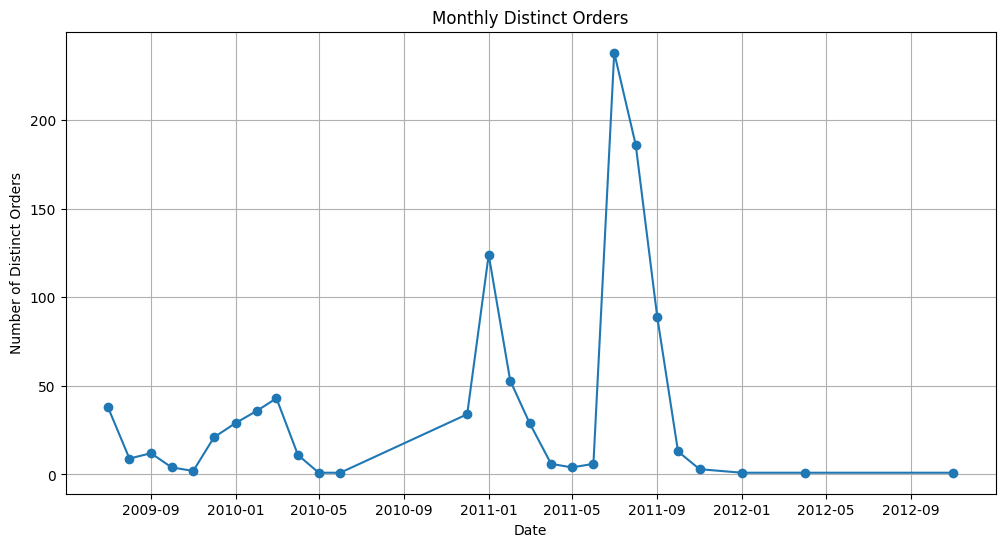

ADF Statistic: -3.4018288866287194
p-value: 0.010896682768471203
                                      SARIMAX Results                                      
Dep. Variable:                 Customer Order Code   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                   3.658
Date:                             Sun, 08 Dec 2024   AIC                              0.684
Time:                                     01:03:59   BIC                             -7.316
Sample:                                          0   HQIC                              -inf
                                              - 27                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3624   3.01e-06    1.2e+

/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/Users/sam/Library/Python/3.

<Figure size 1500x1000 with 0 Axes>

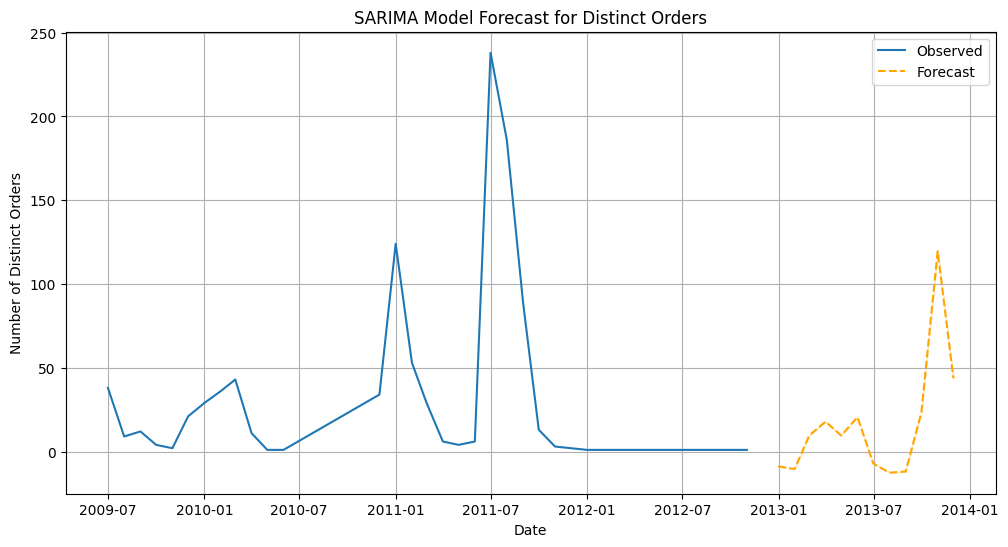

In [4]:
import pandas as pd
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load the dataset
df = pd.read_csv('/Users/Sam/Downloads/data_set_hackathon.csv')

# Parse dates and extract month and year
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')

# Group by month and count distinct Customer Order Codes
df['Year-Month'] = df['order_date'].dt.to_period('M')
monthly_orders = df.groupby('Year-Month')['Customer Order Code'].nunique().reset_index()
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].astype(str)

# Convert to time series
monthly_orders_ts = monthly_orders.set_index('Year-Month')['Customer Order Code']

# Ensure the index is datetime for SARIMA
monthly_orders_ts.index = pd.to_datetime(monthly_orders_ts.index)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders_ts, marker='o')
plt.title('Monthly Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Number of Distinct Orders')
plt.grid(True)
plt.show()

# Check stationarity
adf_test = adfuller(monthly_orders_ts)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Differencing if not stationary
if adf_test[1] > 0.05:
    monthly_orders_diff = monthly_orders_ts.diff().dropna()
else:
    monthly_orders_diff = monthly_orders_ts

# Fit SARIMA model (simplified parameters to avoid overfitting)
sarima_model = SARIMAX(monthly_orders_ts, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 0, 12),  # Simplified seasonal order
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)

# Model summary
print(sarima_results.summary())

# Plot diagnostics (may warn if too few observations)
try:
    sarima_results.plot_diagnostics(figsize=(15, 10))
    plt.show()
except ValueError as e:
    print("Diagnostics plot skipped due to insufficient data:", e)

# Forecast future values
forecast_steps = 12  # Forecasting 12 months ahead
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_orders_ts.index[-1] + pd.DateOffset(months=1), 
                               periods=forecast_steps, 
                               freq='M')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders_ts, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', linestyle='--', color='orange')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.title('SARIMA Model Forecast for Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Number of Distinct Orders')
plt.legend()
plt.grid(True)
plt.show()

